# 5.3 Binomial Logistic Regression

In [1]:
import os, sys

os.chdir('../../chap05')
print("Current working directory:", os.getcwd())

Current working directory: c:\Users\yongd\Documents\git\Matsuura2022_Bayesian_Statistical_Modeling\chap05


In [2]:
import pandas
import seaborn as sns
import matplotlib.pyplot as plt

d = pandas.read_csv('input/data-shopping-2.csv')
d.Income /= 100
d["proportion"] = d.Y / d.M
d.drop(columns='PersonID', inplace=True)

data = d.to_dict('list')
data.update({'N':len(d)})

d.head()

,Sex,Income,M,Y,proportion
0,0,0.851,9,6,0.666667
1,1,0.646,12,4,0.333333
2,0,0.976,6,5,0.833333
3,1,0.728,9,9,1.000000
4,1,0.511,11,6,0.545455


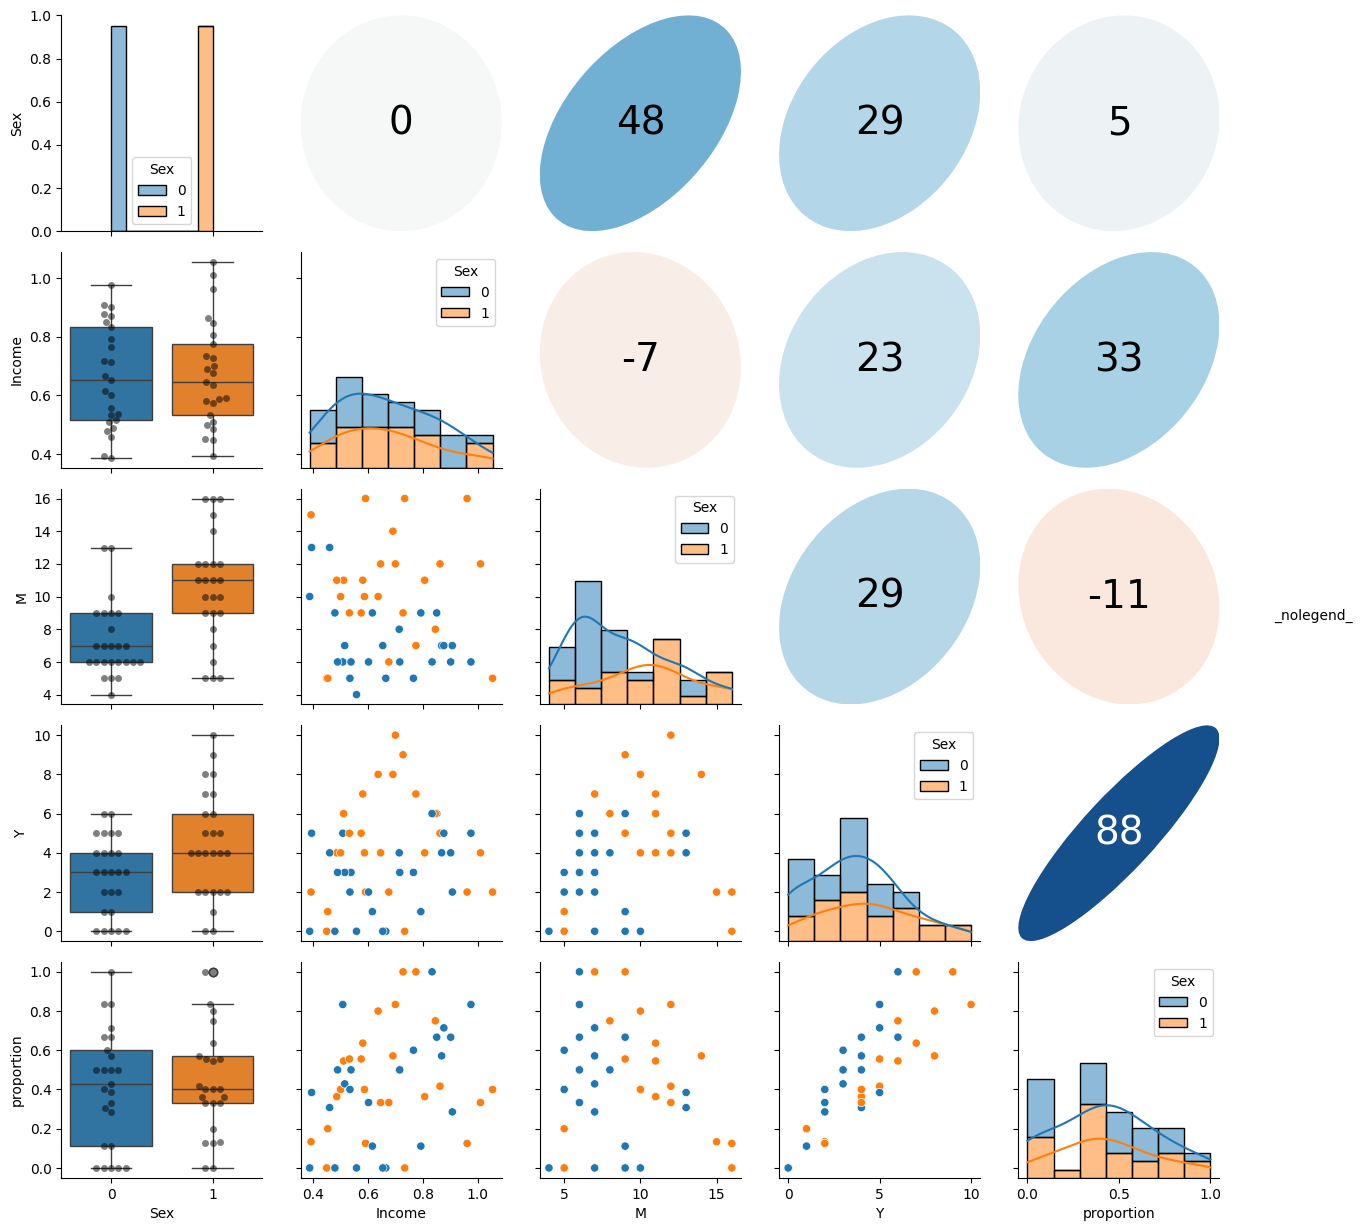

In [3]:
from scipy import stats
import math

def plot_lower(x, y, **kws):
    d_ = pandas.DataFrame({'x':x, 'y':y, 'Sex':d.Sex})
    if x.nunique() < 5:
        sns.boxplot(data=d_, x='x', y='y', hue='Sex')
        sns.swarmplot(data=d_, x='x', y='y', color='black', alpha=0.5)
    else:
        sns.scatterplot(data=d_, x='x', y='y', hue='Sex')

def plot_diag(x, **kws):    
    d_ = pandas.DataFrame({'x':x, 'Sex':d.Sex})
    sns.histplot(data=d_, x='x', hue='Sex', multiple='stack', kde=True)

def plot_upper(x, y, **kws):
    from matplotlib.patches import Ellipse
    r, _ = stats.spearmanr(x, y)
    ax = plt.gca()
    ax.axis('off')
    ellcolor = plt.cm.RdBu(0.5*(r+1))
    txtcolor = 'black' if math.fabs(r) < 0.5 else 'white'
    ax.add_artist(Ellipse(xy=[.5, .5], width=math.sqrt(1+r), height=math.sqrt(1-r), angle=45,
        facecolor=ellcolor, edgecolor='none', transform=ax.transAxes))
    ax.text(.5, .5, '{:.0f}'.format(r*100), color=txtcolor, fontsize=28,
        horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

g = sns.PairGrid(d)
g.map_lower(plot_lower)
g.map_diag(plot_diag)
g.map_upper(plot_upper)
g.add_legend()
plt.show()

In [4]:
import cmdstanpy
model = cmdstanpy.CmdStanModel(stan_file='model/model5-4.stan')

C:\Users\yongd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
print(model.code())

data {
  int N;
  vector<lower=0, upper=1>[N] Sex;
  vector<lower=0>[N] Income;
  array[N] int<lower=0> M;
  array[N] int<lower=0> Y;
}

parameters {
  vector[3] b;
}

transformed parameters {
  vector[N] q = inv_logit(b[1] + b[2]*Sex[1:N] + b[3]*Income[1:N]);
}

model {
  Y[1:N] ~ binomial(M[1:N], q[1:N]);
}

generated quantities {
  array[N] int yp = binomial_rng(M[1:N], q[1:N]);
}



### Model Formula 5.4

$$
\begin{align}
    q[n]  & =  \mathrm{inv\_logit}(b_1 + b_2 Sex[n] + b_3 Income[n]), \quad\quad n=1,...,N \\
    Y[n]  & \sim  \mathrm{Binomial}(M[n], q[n])
\end{align}
$$

In [6]:
# Suppress all output from model.sample() including logger messages
import warnings
import sys
from contextlib import redirect_stdout, redirect_stderr
import os
import logging

# Suppress cmdstanpy logger messages completely
logging.getLogger("cmdstanpy").setLevel(logging.WARNING)
# Or use CRITICAL to suppress even warnings: logging.getLogger("cmdstanpy").setLevel(logging.CRITICAL)

# Method 1: Use show_console=False (most effective)
fit = model.sample(data=data, seed=123, show_console=False, show_progress=False)

print("Sampling completed.")
fit.summary()

Sampling completed.


,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,ESS_bulk/s,R_hat
lp__,-297.865000,0.037068,1.255010,1.022890,-300.401000,-297.549000,-296.502000,1227.17,1496.62,1837.09,1.004140
b[1],-1.490380,0.011041,0.407756,0.400481,-2.157850,-1.494480,-0.822868,1384.24,1307.32,2072.21,1.003770
b[2],0.101659,0.004655,0.200397,0.194221,-0.221954,0.097690,0.442072,1862.00,1865.02,2787.42,1.001970
b[3],1.592060,0.015388,0.572031,0.565119,0.662171,1.583940,2.531030,1412.34,1371.75,2114.29,1.003800
q[1],0.466457,0.000974,0.046549,0.046321,0.391600,0.466592,0.544853,2292.98,2476.05,3432.61,1.001400
...,...,...,...,...,...,...,...,...,...,...,...
yp[46],2.469500,0.019567,1.219610,1.482600,1.000000,2.000000,5.000000,3896.61,4066.14,5833.25,1.000040
yp[47],1.991750,0.019281,1.174530,1.482600,0.000000,2.000000,4.000000,3725.22,3835.71,5576.68,1.000280
yp[48],4.034250,0.024951,1.495710,1.482600,2.000000,4.000000,7.000000,3619.47,3875.93,5418.37,1.000020
yp[49],1.736250,0.018173,1.078880,1.482600,0.000000,2.000000,4.000000,3529.46,3433.69,5283.63,0.999782


In [7]:
# Alternative methods to suppress cmdstanpy output

# Method 2: Complete silence using context managers
def run_silent_sampling():
    # Suppress logger messages
    logging.getLogger("cmdstanpy").setLevel(logging.CRITICAL)
    
    with open(os.devnull, 'w') as devnull:
        with redirect_stdout(devnull), redirect_stderr(devnull):
            return model.sample(data=data, seed=123, parallel_chains=4, show_console=False)

# Method 3: Global logging suppression for cmdstanpy
def suppress_cmdstanpy_logs():
    """Completely suppress all cmdstanpy logging messages"""
    logging.getLogger("cmdstanpy").setLevel(logging.CRITICAL)
    logging.getLogger("cmdstanpy").disabled = True

# Method 4: Temporary logging suppression (context manager)
from contextlib import contextmanager

@contextmanager
def suppress_logs():
    """Context manager to temporarily suppress cmdstanpy logs"""
    logger = logging.getLogger("cmdstanpy")
    original_level = logger.level
    logger.setLevel(logging.CRITICAL)
    try:
        yield
    finally:
        logger.setLevel(original_level)

print("Available methods to suppress cmdstanpy messages:")
print("1. logging.getLogger('cmdstanpy').setLevel(logging.WARNING)  # Suppress INFO")
print("2. logging.getLogger('cmdstanpy').setLevel(logging.CRITICAL) # Suppress all")
print("3. logging.getLogger('cmdstanpy').disabled = True           # Disable completely")
print("4. Use context manager suppress_logs() for temporary suppression")

# Example usage of Method 4:
# with suppress_logs():
#     fit = model.sample(data=data, seed=123, show_console=False)

Available methods to suppress cmdstanpy messages:
1. logging.getLogger('cmdstanpy').setLevel(logging.WARNING)  # Suppress INFO
2. logging.getLogger('cmdstanpy').setLevel(logging.CRITICAL) # Suppress all
3. logging.getLogger('cmdstanpy').disabled = True           # Disable completely
4. Use context manager suppress_logs() for temporary suppression


In [8]:
# Also suppress messages from model.optimize()
mapest = model.optimize(data=data, seed=123, show_console=False)
print(mapest.b)

[-1.458708    0.09767989  1.553779  ]


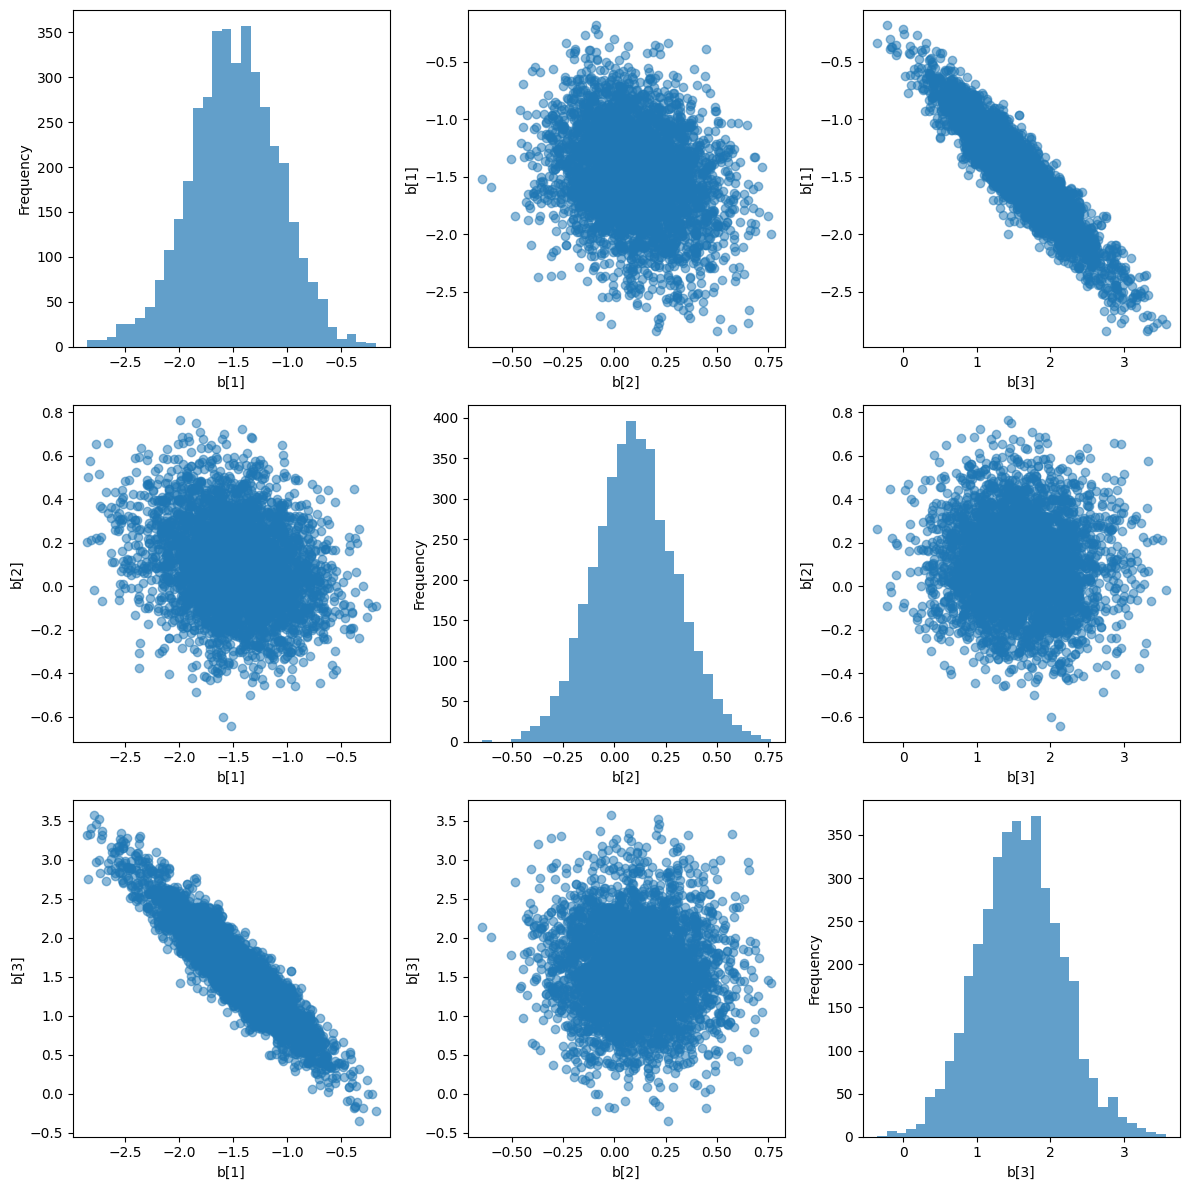

In [9]:
# Extract parameters b[1], b[2], b[3] from the fit
samples = fit.draws_pd()
b_params = samples[['b[1]', 'b[2]', 'b[3]']]

# Create 3x3 scatter plot matrix
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

param_names = ['b[1]', 'b[2]', 'b[3]']

for i in range(3):
    for j in range(3):
        if i == j:
            # Diagonal: histograms
            axes[i, j].hist(b_params[param_names[i]], bins=30, alpha=0.7)
            axes[i, j].set_xlabel(param_names[i])
            axes[i, j].set_ylabel('Frequency')
        else:
            # Off-diagonal: scatter plots
            axes[i, j].scatter(b_params[param_names[j]], b_params[param_names[i]], alpha=0.5)
            axes[i, j].set_xlabel(param_names[j])
            axes[i, j].set_ylabel(param_names[i])

plt.tight_layout()
plt.show()

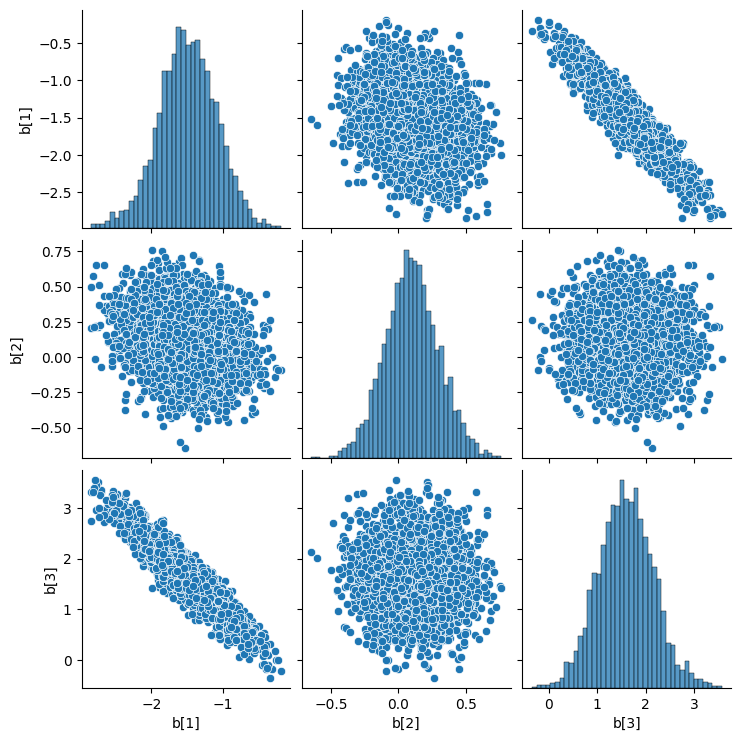

In [10]:
sns.pairplot(data=b_params);plt.show()

In [11]:
import numpy as np

def logit(x):
    return 1 / (1 + np.exp(-x))

In [12]:
q = logit(b_params['b[1]'] + b_params['b[2]'] * d.Sex[0] + b_params['b[3]'] * d.Income[0])
print(q.describe())
print(q.head())

count    4000.000000
mean        0.466457
std         0.046549
min         0.313664
25%         0.434688
50%         0.466592
75%         0.497047
max         0.624773
dtype: float64
0    0.462663
1    0.409946
2    0.443530
3    0.515770
4    0.439777
dtype: float64


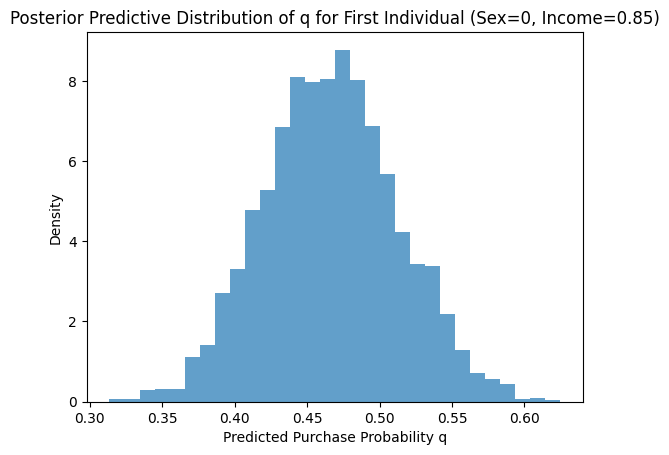

In [13]:
plt.hist(q, bins=30, alpha=0.7, density=True)
plt.xlabel('Predicted Purchase Probability q')
plt.ylabel('Density')
plt.title(f'Posterior Predictive Distribution of q for First Individual (Sex={d.Sex[0]}, Income={d.Income[0]:.2f})')
plt.show()

[2 5 2 ... 6 5 4] shape: (4000,)
The number of visits: 9


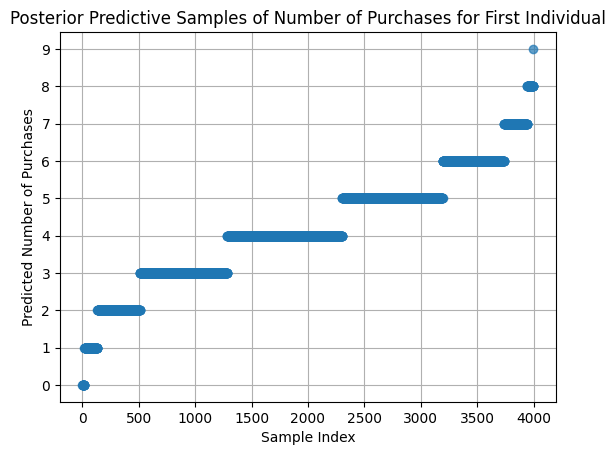

In [14]:
# predictive sampling
import scipy.stats as stats
y_pred_samples = stats.binom.rvs(n=int(d.M[0]), p=q, size=len(q))
print(y_pred_samples, "shape:", y_pred_samples.shape)

print("The number of visits:", int(d.M[0]))

y_pred_samples = np.sort(y_pred_samples) # sort for better visualization

plt.plot(y_pred_samples, marker='o', linestyle='', alpha=0.7);
plt.yticks(range(int(d.M[0])+1))
plt.xlabel('Sample Index')
plt.ylabel('Predicted Number of Purchases')
plt.title('Posterior Predictive Samples of Number of Purchases for First Individual')
plt.grid(True)
plt.show()

CORRECT binning for discrete data 0 to 9:
Bin edges: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Number of bins: 10
Bins represent: [0,1), [1,2), [2,3), ..., [9,10)
This captures all values 0,1,2,...,9

Density values: [4.2500e-03 2.9000e-02 9.4250e-02 1.9350e-01 2.5500e-01 2.2250e-01
 1.3625e-01 5.1250e-02 1.3750e-02 2.5000e-04]
Sum of densities × bin_width: 1.0 (should be 1.0 for density=True)

Data verification:
Min value in data: 0
Max value in data: 9
All values captured: True


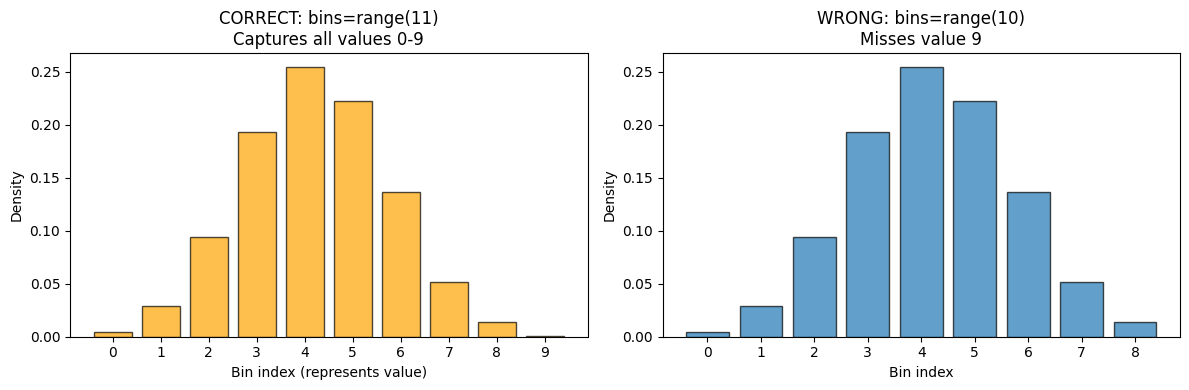

In [15]:
# Correct way to handle discrete data for complete range 0 to M

# Problem: bins=range(int(d.M[0])+1) gives [0,1,2,...,9] 
# This creates bins [0,1), [1,2), ..., [8,9) - missing values that equal 9!

# Solution: Use bins=range(int(d.M[0])+2) to include all possible values
correct_bins = range(int(d.M[0]) + 2)  # [0, 1, 2, ..., 9, 10]
correct_counts, correct_edges = np.histogram(y_pred_samples, bins=correct_bins, density=True)

print("CORRECT binning for discrete data 0 to 9:")
print(f"Bin edges: {list(correct_edges)}")
print(f"Number of bins: {len(correct_counts)}")
print(f"Bins represent: [0,1), [1,2), [2,3), ..., [9,10)")
print(f"This captures all values 0,1,2,...,9")

print(f"\nDensity values: {correct_counts}")
print(f"Sum of densities × bin_width: {np.sum(correct_counts)} (should be 1.0 for density=True)")

# Verify no data is lost
print(f"\nData verification:")
print(f"Min value in data: {y_pred_samples.min()}")
print(f"Max value in data: {y_pred_samples.max()}")
print(f"All values captured: {y_pred_samples.min() >= 0 and y_pred_samples.max() < 10}")

# Compare the two approaches
fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(12, 4))

# Wrong way (missing data at boundary)
wrong_counts, wrong_edges = np.histogram(y_pred_samples, bins=range(int(d.M[0])+1), density=True)
ax1.bar(range(len(wrong_counts)), wrong_counts, alpha=0.7, edgecolor='black')
ax1.set_title('WRONG: bins=range(10)\nMisses value 9')
ax1.set_xlabel('Bin index')
ax1.set_ylabel('Density')
ax1.set_xticks(range(len(wrong_counts)))

# Correct way
ax2.bar(correct_bins[:-1], correct_counts, alpha=0.7, edgecolor='black', color='orange')
ax2.set_title('CORRECT: bins=range(11)\nCaptures all values 0-9')
ax2.set_xlabel('Bin index (represents value)')
ax2.set_ylabel('Density')
ax2.set_xticks(range(len(correct_counts)))

plt.tight_layout()
plt.show()

끝.